# 随机激光光谱深度学习Keras
1.14

## 导入所需的库

In [1]:
import graphviz
import keras.backend
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import *
from keras.losses import mean_squared_error
from keras.models import *
from keras.utils import plot_model
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# import pydot_ng as pydot
from tensorflow.keras.utils import plot_model
import cv2
np.random.seed(10)

Using TensorFlow backend.


## 导入光谱数据

In [2]:
# 输入数据
sum_data = np.load("mod5000.npy")
x = np.load("x.npy")

In [3]:
sum_data.shape

(43, 5000)

Text(0.5, 1.0, 'Spectrum')

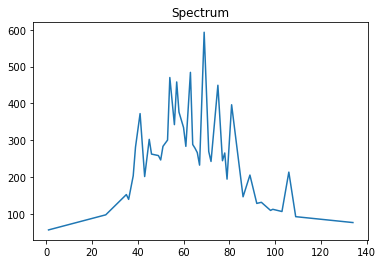

In [4]:
# 作图查看
plt.figure()
plt.plot(x,sum_data[:,1])
plt.title("Spectrum")

# 取点
# [start, end] = plt.ginput(2)
# x1, y1 = start[0], start[1]
# x2, y2 = end[0], end[1]

In [5]:
# 保留光谱值并竖向转置
DataY = sum_data.T
frame = DataY.shape[0]
frame, DataY.shape

(5000, (5000, 43))

## 光谱归一化与标准化的对比

In [6]:
# Z-Score标准化的评估器实现方法  均按列转换

X = DataY  # 导入数据
scaler = StandardScaler()
train_x, test_x = train_test_split(
    X, train_size=int(0.8 * frame), test_size=int(0.2 * frame), shuffle=False
)

# scaler.inverse_transform() 逆转换

# 0-1标准化的评估器实现方法

scaler = MinMaxScaler()
train_x_col_norm = scaler.fit_transform(X)  # 对比，列归一化

train_x_row_norm = scaler.fit_transform(X.T).T  # 对比，行归一化

# 一步执行在X_train上fit和transfrom两个操作
scaler = StandardScaler()
train_x_col_std = scaler.fit_transform(train_x)
test_x_col_std = scaler.fit_transform(test_x.T).T 

train_x_row_std = scaler.fit_transform(train_x.T).T
test_x_row_std = scaler.fit_transform(
    test_x.T
).T  # 非通道，若以训练集的均值和标准差转换测试集--scaler.tansform,

# 赋值替代
train_x = train_x_row_std
test_x = test_x_row_std

Text(0.5, 1.0, 'Row_std Spectrum')

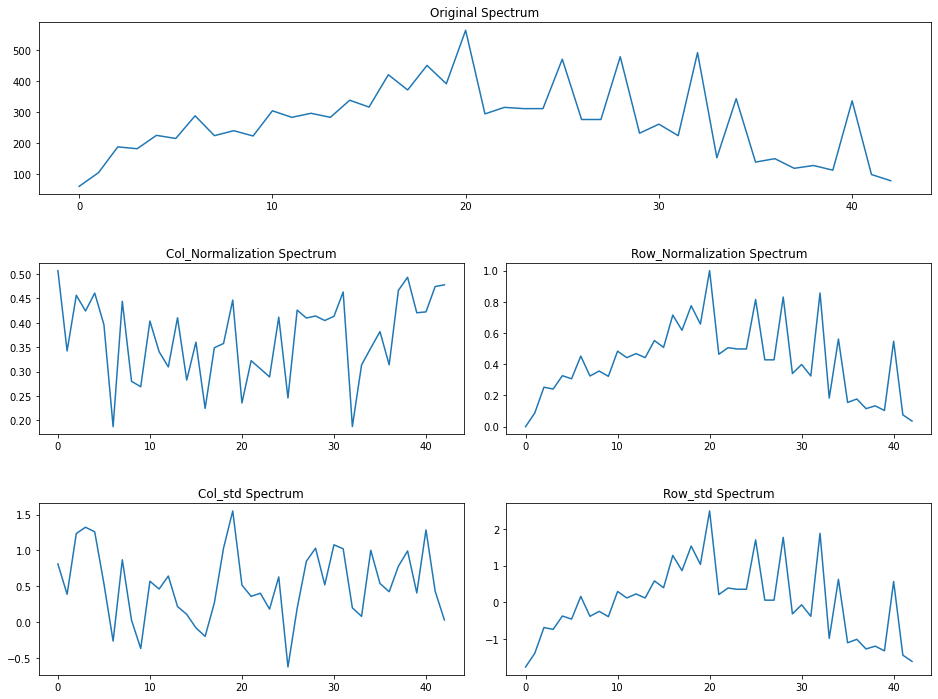

In [7]:
# 作图查看
fig = plt.figure(figsize=(16, 12))  # 宽，高
fig.subplots_adjust(hspace=0.4, wspace=0.1)  # 间距
# gs = fig.add_gridspec(2, 2) 一图占多位
# plt.subplot(gs[0,0])

plt.subplot2grid((3, 2), (0, 0), colspan=2)  # (行列分布)，（起始区），rowspan 列合并
plt.plot(X[0, :])  # 第一行
plt.title("Original Spectrum")

plt.subplot(323)
plt.plot(train_x_col_norm[0, :])  # 第一行
plt.title("Col_Normalization Spectrum")  # 列数据缩放到[0,1]范围内，缺点是受极值影响。

plt.subplot(324)
plt.plot(train_x_row_norm[0, :])  # 第一行
plt.title("Row_Normalization Spectrum")

plt.subplot(325)
plt.plot(train_x_col_std[0, :])  # 第一行
plt.title("Col_std Spectrum")  # 数据处理成均值为0，方差为1的数据。优点是受异常值影响较小

plt.subplot(326)
plt.plot(train_x_row_std[0, :])  # 第一行
plt.title("Row_std Spectrum")

In [8]:
# # 数据集标准化
# mu = np.mean(DataY, 0)  # 0,1方向
# sigma = np.std(DataY, 0)
# Data_stdn = (DataY - mu) / (sigma)   # DataY mu要满足列数相等
# Data_stdn = Data_stdn

# # 特征标准化（波形不变）
# mu = np.mean(DataY, 1)  # 0,1方向
# sigma = np.std(DataY, 1)
# Data_stdn = (DataY.T - mu) / (sigma)   #满足列数相等
# Data_stdn = Data_stdn.T

# mu.shape,Data_stdn.shape

# # 训练集与测试集
# train = Data_stdn[ 0 : int(0.9 * frame),:]  # float转int
# test = Data_stdn[ int(0.9 * frame) : frame,:]
# train.shape,test.shape

train_frame = train_x.shape[0]
test_frame = test_x.shape[0]
train_frame, test_frame

(4000, 1000)

Text(0.5, 1.0, 'Standardization Spectrum')

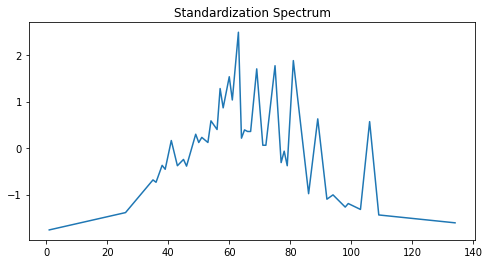

In [9]:
# 作图查看
plt.figure(figsize=(8, 4))
plt.plot(x,train_x[0, :])  # 第一行
plt.title("Standardization Spectrum")

In [10]:
# np.save('train_x_life',train_x)
# from scipy import io
# mat=np.load('train_x_life.npy')
# io.savemat('train_x_life.mat', {'train_x_life': mat})

## 分离单一波长

In [11]:
# 分批次
l=DataY.shape[1]
predict_step=3
time_step = l-predict_step   #16 32
predict_index=20


train_X = np.expand_dims(np.concatenate((train_x[:, :predict_index], train_x[:, predict_index+1:l]), axis=1),axis=1) 
train_Y = np.expand_dims(np.expand_dims(train_x[:, predict_index],axis=1) ,axis=1) 
print(train_X.shape)
print(train_Y.shape)

(4000, 1, 42)
(4000, 1, 1)


In [12]:
test_X = np.expand_dims(np.concatenate((test_x[:, :predict_index], test_x[:, predict_index+1:l]), axis=1),axis=1) 
test_Y = np.expand_dims(np.expand_dims(test_x[:, predict_index],axis=1) ,axis=1) 
print(test_X.shape)
print(test_Y.shape)

(1000, 1, 42)
(1000, 1, 1)


## 构建神经网络层 Conv1D+BiLSTM+Attention

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 42)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 128)            5504      
_________________________________________________________________
dense_2 (Dense)              (None, 1, 8)              1032      
_________________________________________________________________
dense_3 (Dense)              (None, 1, 32)             288       
_________________________________________________________________
dense_4 (Dense)              (None, 1, 1)              33        
Total params: 6,857
Trainable params: 6,857
Non-trainable params: 0
_________________________________________________________________


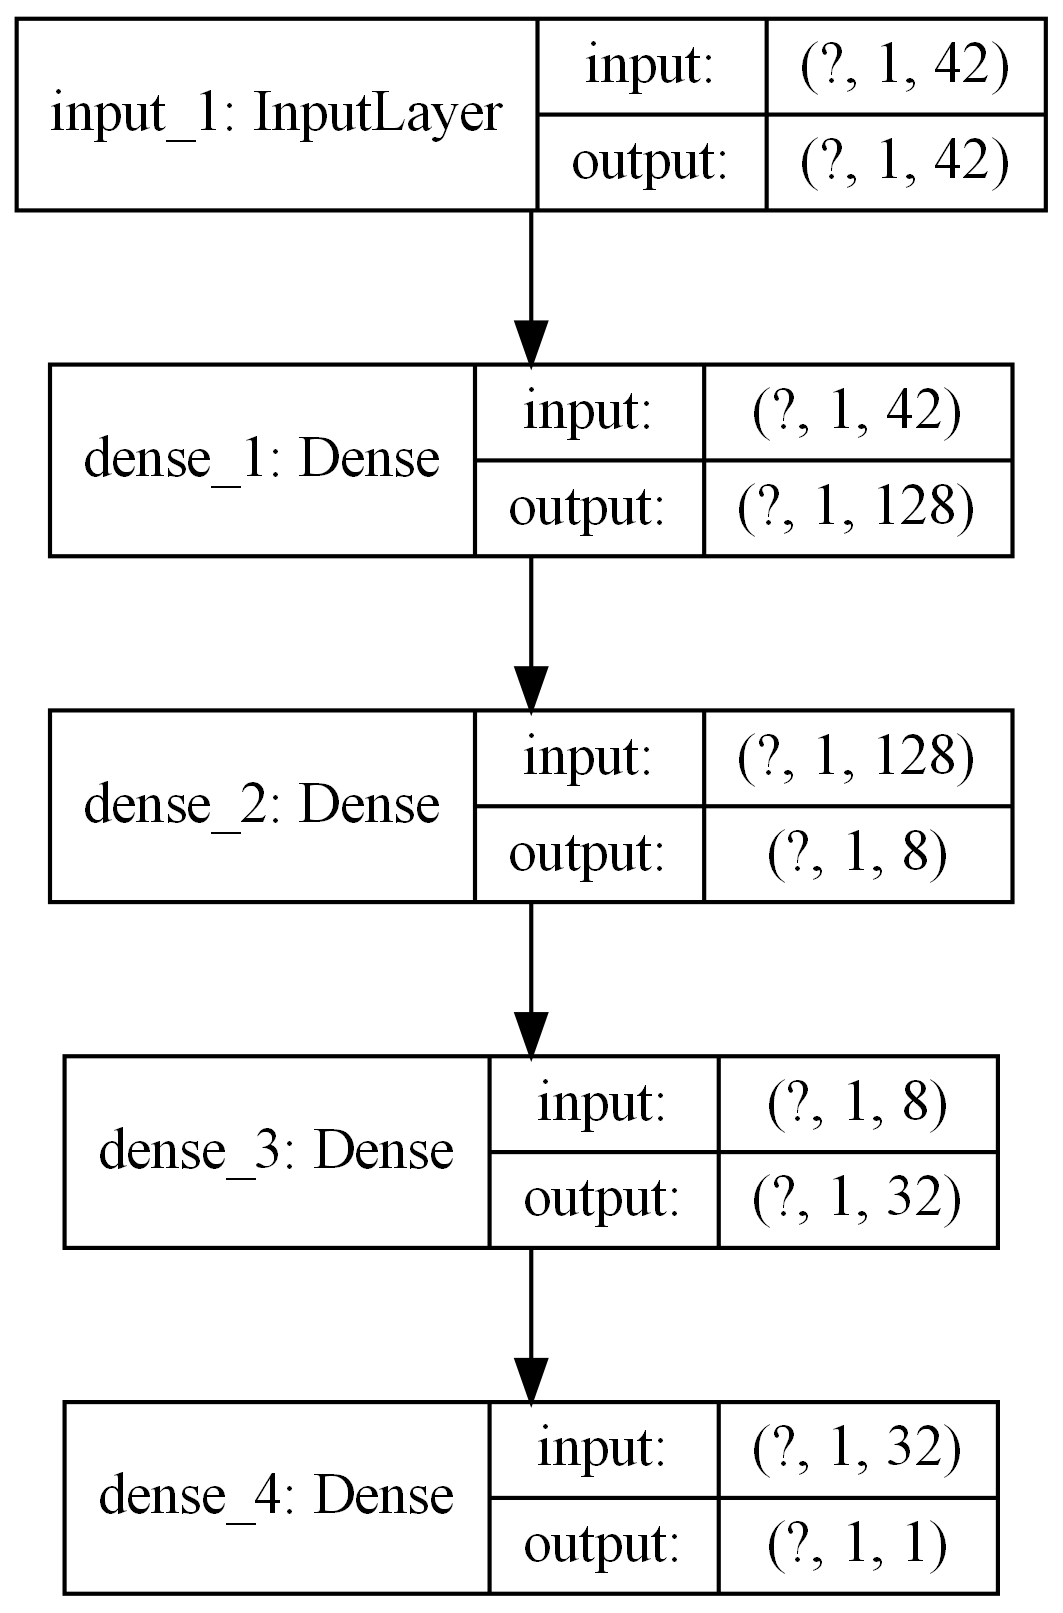

In [13]:
# Model式
lstm_units = 128
dropout = 0.1
pool_size=2

inputs = Input(shape=(1,42))

# Dense compasion
model = Dense(128)(inputs) 
model = Dense(8)(model) 
model = Dense(32)(model) 
predictions=Dense(1, activation="elu")(model)  # mape 39

# 多个Dense1输出，效果一般
# predictions=[]
# model = Add()([model,lambda_sum]) #activation="softmax"
# for i in range(numChannels):
#     x=Dense(1,name='Dense{}'.format(i+1))(model)
#     predictions.append(x)
# predictions = Lambda(lambda x:keras.backend.concatenate(x, axis=1))(predictions)

model = Model(inputs=inputs, outputs=predictions)

# 配置训练模型
model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
# 优化器选择：SGD,RMSprop,Adam,AdamW,Adadelta,Adagrad,Adamax,Adafactor,Nadam,Ftrl
model.summary()  # 展示模型结构

plot_model(model, show_shapes=True, show_layer_names=True,to_file='model_1peak.png',dpi=300)  # 展示输入输出表格

In [25]:
# data=[]
# for i in range(10):
#     data.append(i)
    
# np.array(data).shape

In [26]:
#设置回调
# TensorBoard = keras.callbacks.TensorBoard(histogram_freq=1,write_graph=True) # tensorboard --logdir=F:\MATLAB\MATLAB_Scripts\JupyterLab_Projects\logs --host=127.0.0.1

# def scheduler(epoch, lr):
#     if epoch < 5:
#         return lr
#     else:
#         return lr * tf.math.exp(-0.1)
# LearningRateScheduler=keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

# ReduceLROnPlateau=keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)  #优化停止时减少学习率
EarlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)  #早停

Train on 4000 samples, validate on 1000 samples
Epoch 1/15
 - 0s - loss: 0.5286 - accuracy: 0.0000e+00 - val_loss: 0.2324 - val_accuracy: 0.0000e+00
Epoch 2/15
 - 0s - loss: 0.1618 - accuracy: 0.0000e+00 - val_loss: 0.0828 - val_accuracy: 0.0000e+00
Epoch 3/15
 - 0s - loss: 0.0696 - accuracy: 0.0000e+00 - val_loss: 0.0484 - val_accuracy: 0.0000e+00
Epoch 4/15
 - 0s - loss: 0.0463 - accuracy: 0.0000e+00 - val_loss: 0.0302 - val_accuracy: 0.0000e+00
Epoch 5/15
 - 0s - loss: 0.0282 - accuracy: 0.0000e+00 - val_loss: 0.0198 - val_accuracy: 0.0000e+00
Epoch 6/15
 - 0s - loss: 0.0188 - accuracy: 0.0000e+00 - val_loss: 0.0090 - val_accuracy: 0.0000e+00
Epoch 7/15
 - 0s - loss: 0.0071 - accuracy: 0.0000e+00 - val_loss: 0.0034 - val_accuracy: 0.0000e+00
Epoch 8/15
 - 0s - loss: 0.0033 - accuracy: 0.0000e+00 - val_loss: 0.0021 - val_accuracy: 0.0000e+00
Epoch 9/15
 - 0s - loss: 0.0028 - accuracy: 0.0000e+00 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 10/15
 - 0s - loss: 0.0021 - accuracy

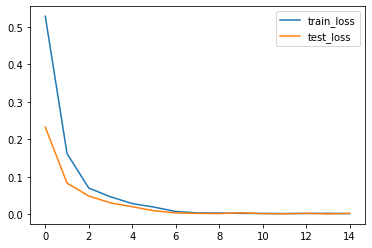

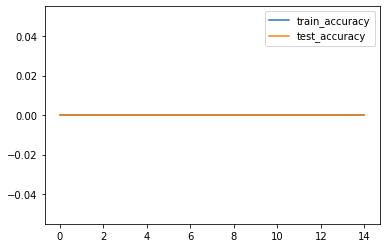

In [27]:
# 训练模型，以 xx 个样本为一个 batch 进行迭代
train = model.fit(
    train_X,
    train_Y,
    epochs=15,
    batch_size=32, # 16 32 64
    validation_data=(test_X, test_Y),
    verbose=2,
    shuffle=True,
    # callbacks=[TensorBoard]
)


# 可视化进度
plt.plot(train.history["loss"], label="train_loss")
plt.plot(train.history["val_loss"], label="test_loss")
plt.legend()
plt.show()

plt.plot(train.history["accuracy"], label="train_accuracy")
plt.plot(train.history["val_accuracy"], label="test_accuracy")
plt.legend()
plt.show()
# %load_ext tensorboard
# %tensorboard --logdir F:\MATLAB\MATLAB_Scripts\JupyterLab_Projects\logs

## 预测光谱数据

In [ ]:
np.save('train_Y_nostd',train_Y)
from scipy import io
mat=np.load('train_Y_nostd.npy')
io.savemat('train_Y_nostd.mat', {'train_Y_nostd': mat})

In [28]:
# 在测试集上的预测
test_Y_predict = model.predict(test_X)
test_Y_predict.shape, test_Y.shape

((1000, 1, 1), (1000, 1, 1))

Text(0.5, 1.0, 'Test Data 1')

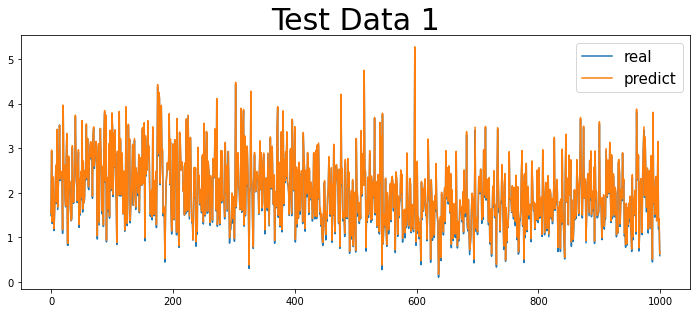

In [29]:
fig = plt.figure(figsize=(16,32))  # 宽，高
fig.subplots_adjust(hspace=0.3, wspace=0.1,top=3)  # 间距
plt.subplot(411)
draw = pd.concat([pd.DataFrame(test_Y[:,0, 0]), pd.DataFrame(test_Y_predict[:,0, 0])], axis=1)
draw.iloc[:, 0].plot(figsize=(12, 6))
draw.iloc[:, 1].plot(figsize=(12, 6))
plt.legend(("real", "predict"), fontsize="15")
plt.title("Test Data 1", fontsize="30")  # 添加标题

In [30]:
# 输出结果
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

# 平均绝对误差（Mean Absolute Error，MAE）

# 均方误差（Mean Square Error，MSE）
# 平均绝对百分比误差（Mean Absolute Percentage Error，MAPE）

y=np.squeeze(test_Y_predict)
Y=np.squeeze(test_Y)
print("测试集上的")
print(mean_absolute_error(y,Y))
print(mean_squared_error(y,Y))
print(np.sqrt(mean_squared_error(y,Y)))
print(mape(Y,y))

测试集上的
0.04250290745495009
0.002303676351318528
0.04799662854116451
2.848807240996128


In [ ]:
(test_x).shape,test_X.shape

In [ ]:
np.squeeze(test_Y,1).shape

In [31]:
recover=np.concatenate((test_x[:, :predict_index],np.squeeze(test_Y_predict,1), test_x[:, predict_index+1:l]), axis=1)
recover.shape

(1000, 43)

Text(0.5, 1.0, 'Test Data 1')

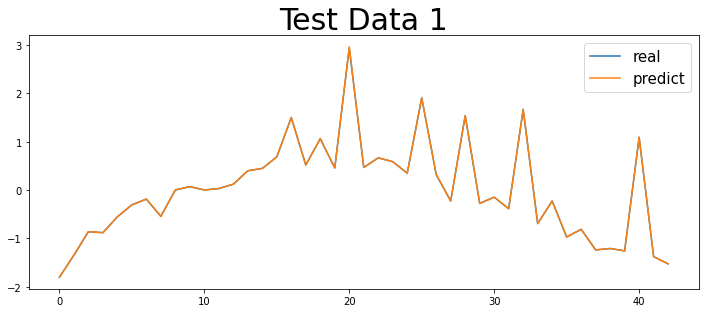

In [32]:
fig = plt.figure(figsize=(16,32))  # 宽，高
fig.subplots_adjust(hspace=0.3, wspace=0.1,top=3)  # 间距
plt.subplot(411)
draw = pd.concat([pd.DataFrame(test_x[1,:]), pd.DataFrame(recover[1,:])], axis=1)
draw.iloc[:, 0].plot(figsize=(12, 6))
draw.iloc[:, 1].plot(figsize=(12, 6))
plt.legend(("real", "predict"), fontsize="15")
plt.title("Test Data 1", fontsize="30")  # 添加标题

In [34]:
np.save('test_Y_p1',test_Y)
np.save('test_Y_p1_predict',test_Y_predict)
from scipy import io
mat=np.load('test_Y_p1.npy')
io.savemat('test_Y_p1.mat', {'test_Y_p1': mat})
mat1=np.load('test_Y_p1_predict.npy')
io.savemat('test_Y_p1_predict.mat', {'test_Y_p1_predict': mat1})

In [ ]:
for i in range(4):
    print(i)

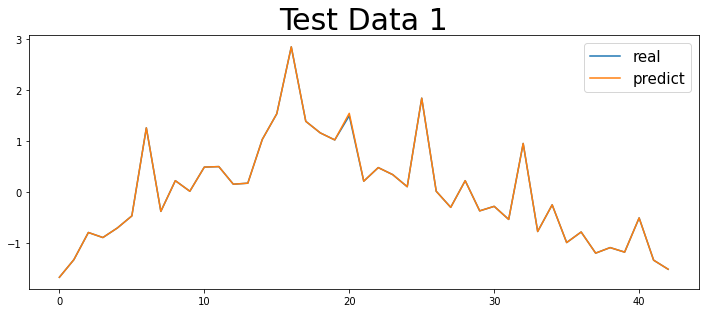

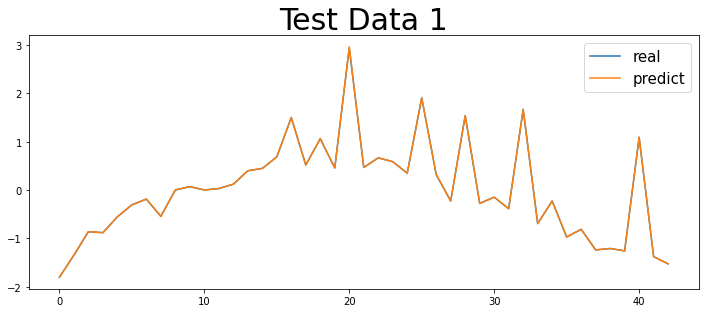

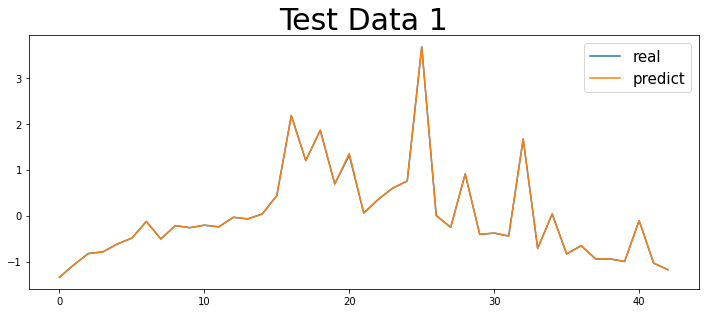

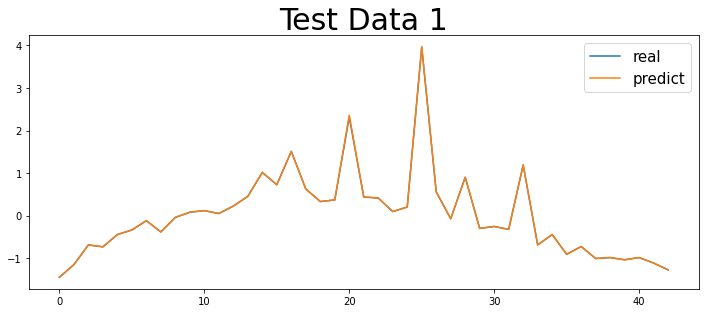

In [33]:

for i in range(4): 
    fig = plt.figure(figsize=(16,32))  # 宽，高
    fig.subplots_adjust(hspace=0.3, wspace=0.1,top=3)  # 间距
    plt.subplot(411)
    draw = pd.concat([pd.DataFrame(test_x[i,:]), pd.DataFrame(recover[i,:])], axis=1)
    draw.iloc[:, 0].plot(figsize=(12, 6))
    draw.iloc[:, 1].plot(figsize=(12, 6))
    plt.legend(("real", "predict"), fontsize="15")
    plt.title("Test Data 1", fontsize="30")  # 添加标题

In [ ]:
# 输出结果
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

# 平均绝对误差（Mean Absolute Error，MAE）

# 均方误差（Mean Square Error，MSE）
# 平均绝对百分比误差（Mean Absolute Percentage Error，MAPE）

y=np.squeeze(test_Y_predict[:,1,:])
Y=np.squeeze( test_Y[:,1,:])
print("测试集上的")
print("MAE:{}".format(mean_absolute_error(y,Y))
print("MSE:{}".format(mean_squared_error(y, Y))
print("RMSE:{}".format(np.sqrt(mean_squared_error(test_Y_predict, test_Y))))
print("MAPE:{}".format(mape(test_Y_predict, test_Y)))

In [ ]:
np.squeeze(test_Y_predict[:,1,:]).shape

In [ ]:
# 去标准化
indexY = test_Y.shape[0]
scaler.fit(DataY[frame - indexY : frame + 1, :].T)
test_Y_inv = scaler.inverse_transform(test_Y.T).T
test_Y_predict_inv = scaler.inverse_transform(test_Y_predict.T).T

draw2 = pd.concat([pd.DataFrame(test_Y_inv[1, :]), pd.DataFrame(test_Y_predict_inv[1, :])], axis=1)
draw2.iloc[:, 0].plot(figsize=(12, 6))
draw2.iloc[:, 1].plot(figsize=(12, 6))
plt.legend(("real", "predict"), fontsize="15")
plt.title("Inverse Transform Test Data 2", fontsize="30")  # 添加标题

In [ ]:
# cnn_test_Y_predict=test_Y_predict
# np.save('5000_long_test_Y_predict',cnn_test_Y_predict)
from scipy import io
mat1=np.load('5000_long_test_Y.npy')
# mat1.shape
io.savemat('long_test_Y_5000.mat', {'long_test_Y_5000': mat1})

In [ ]:
Y=test_Y[0:256,71:135]
Y_predict=test_Y_predict[0:256,71:135]
Y.shape
np.save('test_Yzhu',Y)
np.save('test_Yzhu_predict',Y_predict)
from scipy import io
mat=np.load('test_Yzhu.npy')
io.savemat('test_Yzhu.mat', {'test_Yzhu': mat})
mat1=np.load('test_Yzhu_predict.npy')
io.savemat('test_Yzhu_predict.mat', {'test_Yzhu_predict': mat1})

In [ ]:
plt.figure()
plt.imshow(Y, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()
Y=cv2.resize(Y,(128,128))
Y_predict=cv2.resize(Y_predict,(128,128))
plt.figure()
plt.imshow(Y, cmap='gray')
plt.title('Y')
plt.axis('off')
plt.show()

plt.figure()
plt.imshow(Y_predict, cmap='gray')
plt.title('Y_predict')
plt.axis('off')
plt.show()

# def fun_Arnold(I,a,b,n):
#     [x,y]=I.shape
#     encrypt=np.zeros((x,y))

#     for num in range(n):
#         for i in range(x):
#             for j in range(y):  # i j从0开始
#                 xx=np.mod(1*i+b*j,x)
#                 yy=np.mod(a*i+(a*b+1)*j,y)
#                 encrypt[xx,yy]=I[i,j]
#         I=encrypt
#     return I

In [ ]:
# np.tile(Y[0,:],(256,4)).shape

In [ ]:
# Y0256=np.tile(Y[0,:],(256,4))

plt.figure()
plt.imshow(Y0256, cmap='gray')
plt.title('Y0256')
plt.axis('off')
plt.show()

fai_Arnold3=fun_Arnold(Y0256,1,1,6)
plt.imshow(fai_Arnold3, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
Y256=np.tile(Y,(4,4))
Y_predict256=np.tile(Y_predict,(4,4))
plt.figure()
plt.imshow(Y256, cmap='gray')
plt.title('Y256')
plt.axis('off')
plt.show()

plt.figure()
plt.imshow(Y_predict256, cmap='gray')
plt.title('Y_predict256')
plt.axis('off')
plt.show()


In [ ]:
Y=Y256
Y_predict=Y_predict256
fai_Arnold=fun_Arnold(Y,1,1,7)
plt.imshow(fai_Arnold, cmap='gray')
plt.axis('off')
plt.show()

fai_Arnold2=fun_Arnold(Y_predict,1,1,7)
plt.imshow(fai_Arnold2, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
# np.zeros((64,64))

In [ ]:
def fun_PTFT(fai1):
    I=cv2.imread("lena_gray.bmp", 0)

    RP1 = np.exp(1j * 2 * np.pi * fai1)
    RP2 = np.exp(1j * 2 * np.pi * fai1.T)
    IF1=np.fft.fft2(I*RP1);
    g1=abs(IF1);

    IF2=np.fft.ifft2(g1*RP2);
    g=abs(IF2);

    P2=np.exp(1j*np.angle(np.fft.fft2(I*RP1))); 
    P1=np.exp(1j*np.angle(np.fft.ifft2(g1*RP2)));

    g1=abs(np.fft.fft2(g*P1));
    recover=abs(np.fft.ifft2(g1*P2));
    return g

g=fun_PTFT(fai_Arnold)
plt.imshow(g, cmap='gray')
plt.axis('off')
plt.show()

def fun_PTFT_Recover(g,fai1):
    I=cv2.imread("lena_gray.bmp", 0)

    RP1 = np.exp(1j * 2 * np.pi * fai1)
    RP2 = np.exp(1j * 2 * np.pi * fai1.T)
    IF1=np.fft.fft2(I*RP1);
    g1=abs(IF1);
    
    P2=np.exp(1j*np.angle(np.fft.fft2(I*RP1))); 
    P1=np.exp(1j*np.angle(np.fft.ifft2(g1*RP2)));

    g1=abs(np.fft.fft2(g*P1));
    recover=abs(np.fft.ifft2(g1*P2));
    return recover

recover_Y=fun_PTFT_Recover(g,fai_Arnold)
plt.imshow(recover_Y, cmap='gray')
plt.axis('off')
plt.show()

recover_Y_predict=fun_PTFT_Recover(g,fai_Arnold2)
plt.imshow(recover_Y_predict, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
recover_Y0=fun_PTFT_Recover(g,fai_Arnold3)
plt.imshow(recover_Y0, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
Y
np.save('1',Y)

In [ ]:

from scipy import io
mat=np.load('1.npy')
io.savemat('Y.mat', {'Y': mat})


In [ ]:
cv2.imwrite('Y.bmp',Y)
cv2.imwrite('Y_predict.bmp',Y_predict)

In [ ]:
# cv2.imwrite('recover_Y.png',recover_Y)
cv2.imwrite('recover_Y_predict256.png',recover_Y_predict)